# 1. Install and Import Libraries

In [1]:
!pip install -q medmnist torchvision scikit-learn matplotlib seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as transforms
import torchvision
from medmnist import PathMNIST
from sklearn.model_selection import train_test_split


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nnunetv2 2.5.2 requires torch>=2.1.2, but you have torch 2.0.1 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


# 2. Load the Dataset



In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = PathMNIST(split='train', transform=transform, download=True)
test_dataset = PathMNIST(split='test', transform=transform, download=True)
val_dataset = PathMNIST(split='val', transform=transform, download=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205615438/205615438 [05:22<00:00, 637081.17it/s]


Using downloaded and verified file: /Users/kl2418/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/kl2418/.medmnist/pathmnist.npz
Training samples: 89996
Validation samples: 10004
Test samples: 7180


# 3. Examples of the data

In [36]:
class_names

{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}

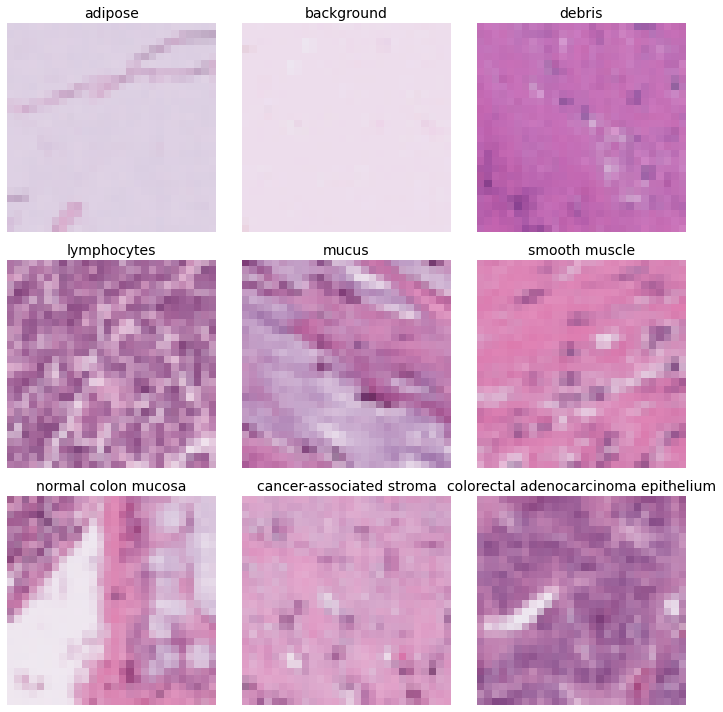

In [19]:
from medmnist import INFO
import matplotlib.pyplot as plt

dataset_info = INFO['pathmnist']
class_names = dataset_info['label']  # keys are strings

def show_one_sample_per_class(dataset):
    # Dictionary to keep one image per label
    seen_labels = {}

    for img, label in dataset:
        label = int(label)
        if label not in seen_labels:
            seen_labels[label] = img
        # Stop early if we have all 9 classes
        if len(seen_labels) == len(class_names):
            break

    # Now plot
    fig, axs = plt.subplots(3, 3, figsize=(10,10))
    for idx, (label, img) in enumerate(sorted(seen_labels.items())):
        img = img.numpy().transpose(1, 2, 0)
        class_name = class_names[str(label)]  # dictionary keys are strings
        axs[idx//3, idx%3].imshow(img)
        axs[idx//3, idx%3].set_title(class_name, fontsize=14)
        axs[idx//3, idx%3].axis('off')

    plt.tight_layout()
    plt.show()

# Call it
show_one_sample_per_class(train_dataset)


# 4) Asses the distrubtion of data
In this section, we analyze the distribution of the different tissue types in the PathMNIST training dataset.

First, we load the dataset metadata, which maps each numeric class label to a corresponding tissue name (e.g., "normal colon mucosa", "colorectal adenocarcinoma epithelium").

We then extract all original labels from the training dataset and build a DataFrame for easier plotting.

Each numeric label is mapped to its tissue name using the metadata, allowing for more readable plots.

Additionally, we define a binary classification target where:

- Cancer (label 1) corresponds to the presence of colorectal adenocarcinoma epithelium (original class 8).

- Non-Cancer (label 0) corresponds to all other tissue types (classes 0-7).

Finally, we plot the distribution of all 9 tissue classes and then the Non-cancer vs Cancer.



In [28]:
binary_labels = []
binary_images = []

for img, label in train_dataset:
    label = int(label)
    if label == 8:  # 8 = colorectal adenocarcinoma epithelium
        binary_labels.append(1)  # Cancer
    else:
        binary_labels.append(0)  # Non-cancer
    binary_images.append(img)

from torch.utils.data import Dataset

class BinaryCancerDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

# Now build the dataset
binary_train_dataset = BinaryCancerDataset(binary_images, binary_labels, transform=None)

print(f"Binary cancer dataset size: {len(binary_train_dataset)}")


Binary cancer dataset size: 89996


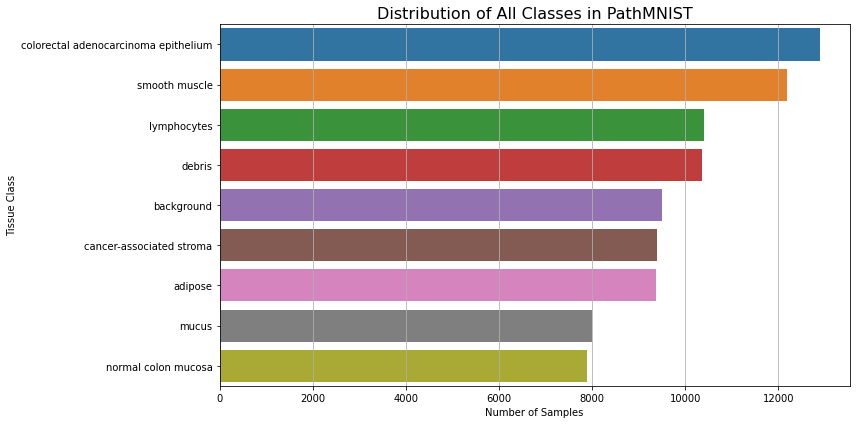

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from medmnist import INFO

# Load PathMNIST metadata
dataset_info = INFO['pathmnist']
class_names = dataset_info['label']  # dictionary: keys are strings

# Step 1: Get all original labels from the dataset
original_labels = [int(label) for _, label in train_dataset]

# Step 2: Build dataframe for original labels
original_df = pd.DataFrame({'label': original_labels})

# Step 3: Map class names for better plot labels
original_df['class_name'] = original_df['label'].map(lambda x: class_names[str(x)])

# Step 4: Create binary labels: 1 if cancer (class 8), else 0
binary_labels = [1 if lbl == 8 else 0 for lbl in original_labels]
binary_df = pd.DataFrame({'cancer': binary_labels})

# ===============================
# 📊 Plot 1: All 9 classes
# ===============================
plt.figure(figsize=(12,6))
sns.countplot(y='class_name', data=original_df, order=original_df['class_name'].value_counts().index)
plt.title('Distribution of All Classes in PathMNIST', fontsize=16)
plt.xlabel('Number of Samples')
plt.ylabel('Tissue Class')
plt.grid(axis='x')
plt.tight_layout()
plt.show()



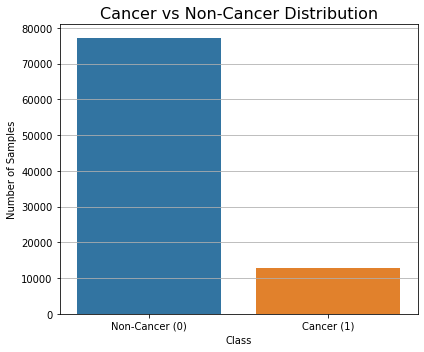

In [27]:
# ===============================
# 📊 Plot 2: Cancer vs Non-Cancer (binary)
# ===============================
plt.figure(figsize=(6,5))
sns.countplot(x='cancer', data=binary_df)
plt.title('Cancer vs Non-Cancer Distribution', fontsize=16)
plt.xticks([0, 1], ['Non-Cancer (0)', 'Cancer (1)'])
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# 5. Exploring Potential Confounding Variables

In addition to understanding class imbalance, it is important to investigate possible clinical confounders in the PathMNIST dataset. Subtle biases in the data could unintentionally influence model performance, 

## 5.1 Pixel Intensity Distribution (Staining Bias)

Different histology slides can exhibit variability in staining, even when standardized H&E (hematoxylin and eosin) protocols are used. Variations in staining intensity can potentially act as unintended issues for a deep learning model.

We compute the mean pixel intensity for each image and visualize its distribution across tissue classes. A systematic shift in intensity distributions between classes could suggest that stain artifacts are influencing the labels, which could bias the learning process

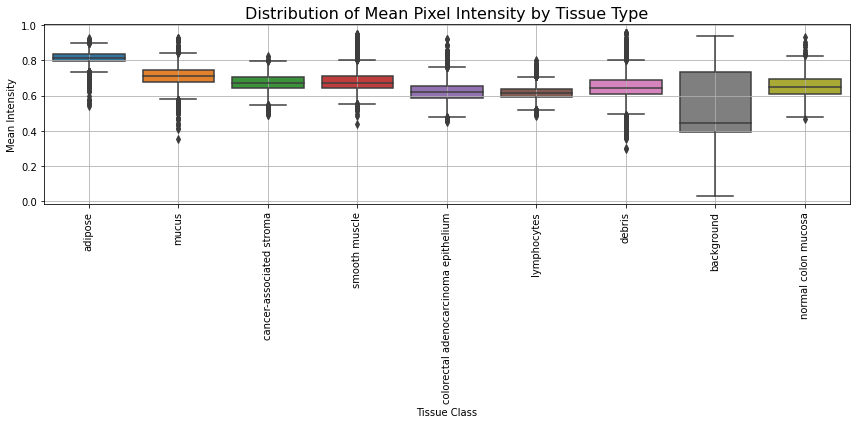

In [32]:
import numpy as np

# Create a simple function to compute mean pixel intensity
def compute_mean_intensity(img):
    return img.numpy().mean()

# For each sample, record its label and mean pixel intensity
intensity_records = []

for img, label in train_dataset:
    label = int(label)
    mean_intensity = compute_mean_intensity(img)
    intensity_records.append((label, mean_intensity))

# Create dataframe
intensity_df = pd.DataFrame(intensity_records, columns=['label', 'mean_intensity'])
intensity_df['class_name'] = intensity_df['label'].map(lambda x: class_names[str(x)])

# Plot
plt.figure(figsize=(12,6))
sns.boxplot(x='class_name', y='mean_intensity', data=intensity_df)
plt.xticks(rotation=90)
plt.title('Distribution of Mean Pixel Intensity by Tissue Type', fontsize=16)
plt.xlabel('Tissue Class')
plt.ylabel('Mean Intensity')
plt.grid()
plt.tight_layout()
plt.show()


## 5.2 Image Sharpness (Blur/Artifact Detection)

Histological images can sometimes be affected by imaging artifacts such as:

    Focus issues (blur),

    Slide folds,

    Debris or dust particles.

Blurry or low-quality images could correlate with specific tissue classes if certain tissue regions are harder to image consistently. To quantify blur, we calculate the Laplacian variance of each image — a simple and effective measure of sharpness. Higher Laplacian variance indicates sharper images; lower variance suggests blur.

Visualizing the blur score distribution across classes helps us identify whether certain tissue types (e.g., cancerous vs non-cancerous) systematically differ in image quality, which could act as a confounding variable in model training.

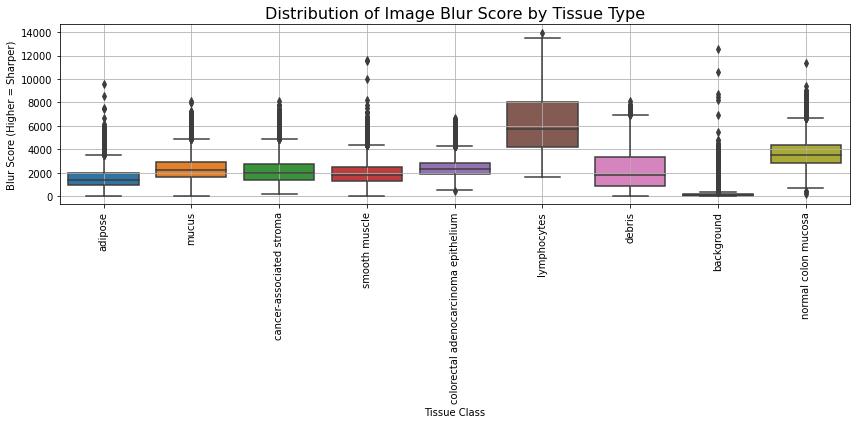

In [30]:
import cv2

# Compute Laplacian variance to estimate blur
def compute_blur(img):
    img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# For each sample, record blur score
blur_records = []

for img, label in train_dataset:
    label = int(label)
    blur_score = compute_blur(img)
    blur_records.append((label, blur_score))

# Create dataframe
blur_df = pd.DataFrame(blur_records, columns=['label', 'blur_score'])
blur_df['class_name'] = blur_df['label'].map(lambda x: class_names[str(x)])

# Plot
plt.figure(figsize=(12,6))
sns.boxplot(x='class_name', y='blur_score', data=blur_df)
plt.xticks(rotation=90)
plt.title('Distribution of Image Blur Score by Tissue Type', fontsize=16)
plt.xlabel('Tissue Class')
plt.ylabel('Blur Score (Higher = Sharper)')
plt.grid()
plt.tight_layout()
plt.show()


# 6. Exercise and Conclusion

In this notebook, we explored the PathMNIST dataset, visualized the distribution of tissue classes, and checked for potential imaging confounders like staining intensity and image blur.

## Important note:
PathMNIST contains no clinical metadata (e.g., patient age, tumor stage, outcomes).
Each patch is treated independently without patient-level context.

## Quick Exercise:

    - What do you think could be a challenge with this data (hint think about the class distrubtions)? 

    - Why is the absence of clinical metadata a limitation for real-world medical AI?

    - If you had access to full clinical data, what variables would you want to explore?

(Hint: think about patient demographics, tumor characteristics, treatment history.)
